In [ ]:
%matplotlib inline

In [ ]:
from dataset_loader import gen_dataloader
from utils import visualize_model

In [ ]:
from torchvision import models
import torch
from torchvision import transforms
from PIL import Image
#from dataset_loader import gen_dataloader
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import os
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [ ]:
writer = SummaryWriter()

In [ ]:
writer_val = SummaryWriter()

In [ ]:
train_data_path = "../input/fairface/FairFace/train"
val_data_path = "../input/fairface/FairFace/val"
models_path = "./models/"
train_labels_path = "../input/fairface/FairFace/train_labels.csv"
val_labels_path = "../input/fairface/FairFace/val_labels.csv"

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize(224), # проверить кроп 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class_to_idx = make_class_to_index(train_labels_path)
train_dataloader, train_size, classes = gen_dataloader(train_data_path, train_labels_path,
                            transformers=data_transforms["train"], batch_size=128, class_to_idx=class_to_idx)
print(classes)

test_dataloader, val_size, classes = gen_dataloader(val_data_path, val_labels_path,
                            transformers=data_transforms["val"], batch_size=128, class_to_idx=class_to_idx)
print(classes)

dataloaders = {
    "train": train_dataloader,
    "val": test_dataloader
}
dataset_sizes = {'train': train_size, 'val': val_size}
dataset_sizes

{'East Asian': 0, 'Indian': 1, 'Black': 2, 'White': 3, 'Middle Eastern': 4, 'Latino_Hispanic': 5, 'Southeast Asian': 6}
{'East Asian': 0, 'Indian': 1, 'Black': 2, 'White': 3, 'Middle Eastern': 4, 'Latino_Hispanic': 5, 'Southeast Asian': 6}


{'train': 86744, 'val': 10954}

In [ ]:
model_ft = models.resnet34(pretrained=True)
# for param in model_ft.parameters():
#     param.requires_grad = False
n = model_ft.fc.in_features
# model_ft.fc = nn.Sequential(
#     nn.Linear(n, 128),
#     nn.ReLU(inplace=True),
#     nn.Linear(128, len(classes))).to(device)
model_ft.fc = nn.Linear(model_ft.fc.in_features, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00009) # Проверить lr/ переделать на adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # Попробовать убрать
exp_lr_scheduler = None
optimizer = optimizer_ft
net = model_ft

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
n_epochs = 15
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in tqdm(enumerate(train_dataloader)):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    writer.add_scalar("Loss/train", running_loss/total_step, epoch)
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in tqdm((test_dataloader)):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        writer_val.add_scalar("Loss/val", batch_loss/len(test_dataloader), epoch)
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet34_00009lr_full.pt')
            # torch.save(net, os.path.join(models_path, "resnet34_best.pth"))
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1



1it [00:08,  8.36s/it]

Epoch [1/15], Step [0/678], Loss: 2.1510


21it [00:45,  1.78s/it]

Epoch [1/15], Step [20/678], Loss: 1.6203


41it [01:21,  1.73s/it]

Epoch [1/15], Step [40/678], Loss: 1.2764


61it [01:56,  1.77s/it]

Epoch [1/15], Step [60/678], Loss: 1.2699


81it [02:32,  1.75s/it]

Epoch [1/15], Step [80/678], Loss: 1.1685


101it [03:07,  1.78s/it]

Epoch [1/15], Step [100/678], Loss: 1.3288


121it [03:43,  1.79s/it]

Epoch [1/15], Step [120/678], Loss: 1.2453


141it [04:18,  1.74s/it]

Epoch [1/15], Step [140/678], Loss: 1.0401


161it [04:53,  1.74s/it]

Epoch [1/15], Step [160/678], Loss: 1.0394


181it [05:29,  1.80s/it]

Epoch [1/15], Step [180/678], Loss: 1.1161


201it [06:06,  1.81s/it]

Epoch [1/15], Step [200/678], Loss: 1.0883


221it [06:41,  1.74s/it]

Epoch [1/15], Step [220/678], Loss: 0.9615


241it [07:16,  1.74s/it]

Epoch [1/15], Step [240/678], Loss: 1.0793


261it [07:52,  1.88s/it]

Epoch [1/15], Step [260/678], Loss: 1.0214


281it [08:28,  1.74s/it]

Epoch [1/15], Step [280/678], Loss: 1.0132


301it [09:03,  1.75s/it]

Epoch [1/15], Step [300/678], Loss: 1.0610


321it [09:38,  1.84s/it]

Epoch [1/15], Step [320/678], Loss: 1.0204


341it [10:14,  1.81s/it]

Epoch [1/15], Step [340/678], Loss: 0.9218


361it [10:51,  1.90s/it]

Epoch [1/15], Step [360/678], Loss: 0.9288


381it [11:27,  1.77s/it]

Epoch [1/15], Step [380/678], Loss: 0.9539


401it [12:03,  1.86s/it]

Epoch [1/15], Step [400/678], Loss: 1.0057


421it [12:39,  1.77s/it]

Epoch [1/15], Step [420/678], Loss: 0.9859


441it [13:14,  1.78s/it]

Epoch [1/15], Step [440/678], Loss: 1.0935


461it [13:50,  1.77s/it]

Epoch [1/15], Step [460/678], Loss: 0.9132


481it [14:25,  1.74s/it]

Epoch [1/15], Step [480/678], Loss: 0.8256


501it [15:00,  1.78s/it]

Epoch [1/15], Step [500/678], Loss: 0.8878


521it [15:34,  1.75s/it]

Epoch [1/15], Step [520/678], Loss: 0.9178


541it [16:09,  1.71s/it]

Epoch [1/15], Step [540/678], Loss: 0.9103


561it [16:44,  1.74s/it]

Epoch [1/15], Step [560/678], Loss: 1.0639


581it [17:18,  1.73s/it]

Epoch [1/15], Step [580/678], Loss: 0.9833


601it [17:53,  1.71s/it]

Epoch [1/15], Step [600/678], Loss: 0.7843


621it [18:27,  1.71s/it]

Epoch [1/15], Step [620/678], Loss: 0.9696


641it [19:02,  1.73s/it]

Epoch [1/15], Step [640/678], Loss: 1.0477


661it [19:37,  1.78s/it]

Epoch [1/15], Step [660/678], Loss: 0.9617


678it [20:06,  1.78s/it]



train-loss: 1.0359, train-acc: 60.3396


100%|██████████| 86/86 [02:11<00:00,  1.53s/it]


validation loss: 0.8937, validation acc: 65.6838

Improvement-Detected, save-model
Epoch 2



1it [00:00,  1.43it/s]

Epoch [2/15], Step [0/678], Loss: 0.8636


21it [00:14,  1.47it/s]

Epoch [2/15], Step [20/678], Loss: 0.6637


41it [00:28,  1.41it/s]

Epoch [2/15], Step [40/678], Loss: 0.9148


61it [00:42,  1.42it/s]

Epoch [2/15], Step [60/678], Loss: 0.7393


81it [00:55,  1.49it/s]

Epoch [2/15], Step [80/678], Loss: 0.8356


101it [01:09,  1.49it/s]

Epoch [2/15], Step [100/678], Loss: 0.8916


121it [01:23,  1.37it/s]

Epoch [2/15], Step [120/678], Loss: 0.8683


141it [01:37,  1.46it/s]

Epoch [2/15], Step [140/678], Loss: 0.8144


161it [01:50,  1.50it/s]

Epoch [2/15], Step [160/678], Loss: 0.6705


181it [02:04,  1.37it/s]

Epoch [2/15], Step [180/678], Loss: 0.8370


201it [02:18,  1.43it/s]

Epoch [2/15], Step [200/678], Loss: 0.8597


221it [02:32,  1.42it/s]

Epoch [2/15], Step [220/678], Loss: 0.7451


241it [02:46,  1.47it/s]

Epoch [2/15], Step [240/678], Loss: 0.7830


261it [02:59,  1.49it/s]

Epoch [2/15], Step [260/678], Loss: 0.7809


281it [03:13,  1.43it/s]

Epoch [2/15], Step [280/678], Loss: 0.7651


301it [03:26,  1.47it/s]

Epoch [2/15], Step [300/678], Loss: 0.7682


321it [03:40,  1.42it/s]

Epoch [2/15], Step [320/678], Loss: 0.8087


341it [03:54,  1.50it/s]

Epoch [2/15], Step [340/678], Loss: 0.8273


361it [04:07,  1.48it/s]

Epoch [2/15], Step [360/678], Loss: 0.8266


381it [04:21,  1.42it/s]

Epoch [2/15], Step [380/678], Loss: 0.7494


401it [04:35,  1.49it/s]

Epoch [2/15], Step [400/678], Loss: 0.5952


421it [04:48,  1.49it/s]

Epoch [2/15], Step [420/678], Loss: 0.7314


441it [05:02,  1.45it/s]

Epoch [2/15], Step [440/678], Loss: 0.9182


461it [05:16,  1.43it/s]

Epoch [2/15], Step [460/678], Loss: 0.9227


481it [05:30,  1.48it/s]

Epoch [2/15], Step [480/678], Loss: 0.6749


501it [05:43,  1.48it/s]

Epoch [2/15], Step [500/678], Loss: 0.6366


521it [05:57,  1.48it/s]

Epoch [2/15], Step [520/678], Loss: 0.7680


541it [06:11,  1.46it/s]

Epoch [2/15], Step [540/678], Loss: 0.7680


561it [06:24,  1.49it/s]

Epoch [2/15], Step [560/678], Loss: 0.9687


581it [06:38,  1.49it/s]

Epoch [2/15], Step [580/678], Loss: 0.7741


601it [06:52,  1.46it/s]

Epoch [2/15], Step [600/678], Loss: 0.6180


621it [07:05,  1.46it/s]

Epoch [2/15], Step [620/678], Loss: 0.7267


641it [07:19,  1.40it/s]

Epoch [2/15], Step [640/678], Loss: 0.8997


661it [07:33,  1.47it/s]

Epoch [2/15], Step [660/678], Loss: 0.8448


678it [07:44,  1.46it/s]



train-loss: 0.9135, train-acc: 70.2008


100%|██████████| 86/86 [00:39<00:00,  2.18it/s]


validation loss: 0.8689, validation acc: 68.2856

Improvement-Detected, save-model
Epoch 3



1it [00:00,  1.51it/s]

Epoch [3/15], Step [0/678], Loss: 0.7452


21it [00:14,  1.51it/s]

Epoch [3/15], Step [20/678], Loss: 0.5897


41it [00:27,  1.49it/s]

Epoch [3/15], Step [40/678], Loss: 0.7404


61it [00:41,  1.45it/s]

Epoch [3/15], Step [60/678], Loss: 0.6325


81it [00:55,  1.46it/s]

Epoch [3/15], Step [80/678], Loss: 0.5759


101it [01:09,  1.45it/s]

Epoch [3/15], Step [100/678], Loss: 0.6328


121it [01:22,  1.49it/s]

Epoch [3/15], Step [120/678], Loss: 0.7547


141it [01:36,  1.40it/s]

Epoch [3/15], Step [140/678], Loss: 0.5327


161it [01:49,  1.50it/s]

Epoch [3/15], Step [160/678], Loss: 0.7126


181it [02:03,  1.43it/s]

Epoch [3/15], Step [180/678], Loss: 0.6038


201it [02:17,  1.49it/s]

Epoch [3/15], Step [200/678], Loss: 0.6509


221it [02:31,  1.39it/s]

Epoch [3/15], Step [220/678], Loss: 0.6491


241it [02:45,  1.44it/s]

Epoch [3/15], Step [240/678], Loss: 0.7304


261it [02:59,  1.43it/s]

Epoch [3/15], Step [260/678], Loss: 0.5261


281it [03:13,  1.47it/s]

Epoch [3/15], Step [280/678], Loss: 0.8239


301it [03:27,  1.40it/s]

Epoch [3/15], Step [300/678], Loss: 0.6174


321it [03:41,  1.37it/s]

Epoch [3/15], Step [320/678], Loss: 0.7236


341it [03:55,  1.40it/s]

Epoch [3/15], Step [340/678], Loss: 0.5899


361it [04:09,  1.46it/s]

Epoch [3/15], Step [360/678], Loss: 0.5805


381it [04:23,  1.45it/s]

Epoch [3/15], Step [380/678], Loss: 0.5687


401it [04:36,  1.48it/s]

Epoch [3/15], Step [400/678], Loss: 0.6353


421it [04:50,  1.50it/s]

Epoch [3/15], Step [420/678], Loss: 0.5371


441it [05:04,  1.50it/s]

Epoch [3/15], Step [440/678], Loss: 0.8195


461it [05:17,  1.44it/s]

Epoch [3/15], Step [460/678], Loss: 0.6377


481it [05:31,  1.47it/s]

Epoch [3/15], Step [480/678], Loss: 0.8300


501it [05:44,  1.50it/s]

Epoch [3/15], Step [500/678], Loss: 0.7850


521it [05:58,  1.49it/s]

Epoch [3/15], Step [520/678], Loss: 0.7387


541it [06:12,  1.45it/s]

Epoch [3/15], Step [540/678], Loss: 0.8300


561it [06:25,  1.48it/s]

Epoch [3/15], Step [560/678], Loss: 0.6985


581it [06:39,  1.48it/s]

Epoch [3/15], Step [580/678], Loss: 0.7241


601it [06:53,  1.48it/s]

Epoch [3/15], Step [600/678], Loss: 0.6404


621it [07:06,  1.47it/s]

Epoch [3/15], Step [620/678], Loss: 0.7949


641it [07:20,  1.40it/s]

Epoch [3/15], Step [640/678], Loss: 0.6992


661it [07:34,  1.47it/s]

Epoch [3/15], Step [660/678], Loss: 0.6979


678it [07:45,  1.46it/s]



train-loss: 0.8373, train-acc: 74.2864


100%|██████████| 86/86 [00:39<00:00,  2.20it/s]


validation loss: 0.8597, validation acc: 68.4590

Improvement-Detected, save-model
Epoch 4



1it [00:00,  1.51it/s]

Epoch [4/15], Step [0/678], Loss: 0.6134


21it [00:14,  1.50it/s]

Epoch [4/15], Step [20/678], Loss: 0.5392


41it [00:27,  1.49it/s]

Epoch [4/15], Step [40/678], Loss: 0.5970


61it [00:41,  1.40it/s]

Epoch [4/15], Step [60/678], Loss: 0.4622


81it [00:55,  1.44it/s]

Epoch [4/15], Step [80/678], Loss: 0.6314


101it [01:09,  1.50it/s]

Epoch [4/15], Step [100/678], Loss: 0.5626


121it [01:23,  1.49it/s]

Epoch [4/15], Step [120/678], Loss: 0.5457


141it [01:36,  1.41it/s]

Epoch [4/15], Step [140/678], Loss: 0.5431


161it [01:50,  1.47it/s]

Epoch [4/15], Step [160/678], Loss: 0.6634


181it [02:03,  1.46it/s]

Epoch [4/15], Step [180/678], Loss: 0.5005


201it [02:17,  1.48it/s]

Epoch [4/15], Step [200/678], Loss: 0.5580


221it [02:31,  1.48it/s]

Epoch [4/15], Step [220/678], Loss: 0.7057


241it [02:44,  1.45it/s]

Epoch [4/15], Step [240/678], Loss: 0.5640


261it [02:58,  1.49it/s]

Epoch [4/15], Step [260/678], Loss: 0.6438


281it [03:11,  1.50it/s]

Epoch [4/15], Step [280/678], Loss: 0.5042


301it [03:25,  1.49it/s]

Epoch [4/15], Step [300/678], Loss: 0.6174


321it [03:39,  1.38it/s]

Epoch [4/15], Step [320/678], Loss: 0.5246


341it [03:53,  1.45it/s]

Epoch [4/15], Step [340/678], Loss: 0.6943


361it [04:06,  1.47it/s]

Epoch [4/15], Step [360/678], Loss: 0.6512


381it [04:20,  1.49it/s]

Epoch [4/15], Step [380/678], Loss: 0.6415


401it [04:34,  1.42it/s]

Epoch [4/15], Step [400/678], Loss: 0.5590


421it [04:48,  1.45it/s]

Epoch [4/15], Step [420/678], Loss: 0.6297


441it [05:01,  1.50it/s]

Epoch [4/15], Step [440/678], Loss: 0.5756


461it [05:15,  1.40it/s]

Epoch [4/15], Step [460/678], Loss: 0.6315


481it [05:29,  1.46it/s]

Epoch [4/15], Step [480/678], Loss: 0.5568


501it [05:42,  1.43it/s]

Epoch [4/15], Step [500/678], Loss: 0.5663


521it [05:56,  1.48it/s]

Epoch [4/15], Step [520/678], Loss: 0.5439


541it [06:10,  1.49it/s]

Epoch [4/15], Step [540/678], Loss: 0.7590


561it [06:24,  1.45it/s]

Epoch [4/15], Step [560/678], Loss: 0.4892


581it [06:37,  1.48it/s]

Epoch [4/15], Step [580/678], Loss: 0.6853


601it [06:51,  1.45it/s]

Epoch [4/15], Step [600/678], Loss: 0.7180


621it [07:05,  1.49it/s]

Epoch [4/15], Step [620/678], Loss: 0.4862


641it [07:18,  1.45it/s]

Epoch [4/15], Step [640/678], Loss: 0.5800


661it [07:32,  1.48it/s]

Epoch [4/15], Step [660/678], Loss: 0.5712


678it [07:44,  1.46it/s]



train-loss: 0.7758, train-acc: 78.0919


100%|██████████| 86/86 [00:39<00:00,  2.16it/s]


validation loss: 0.8633, validation acc: 68.2125

Epoch 5



1it [00:00,  1.50it/s]

Epoch [5/15], Step [0/678], Loss: 0.4312


21it [00:14,  1.48it/s]

Epoch [5/15], Step [20/678], Loss: 0.4758


41it [00:27,  1.44it/s]

Epoch [5/15], Step [40/678], Loss: 0.3479


61it [00:41,  1.48it/s]

Epoch [5/15], Step [60/678], Loss: 0.5329


81it [00:55,  1.45it/s]

Epoch [5/15], Step [80/678], Loss: 0.4299


101it [01:09,  1.46it/s]

Epoch [5/15], Step [100/678], Loss: 0.3537


121it [01:22,  1.49it/s]

Epoch [5/15], Step [120/678], Loss: 0.4590


141it [01:36,  1.43it/s]

Epoch [5/15], Step [140/678], Loss: 0.4334


161it [01:50,  1.44it/s]

Epoch [5/15], Step [160/678], Loss: 0.5832


181it [02:03,  1.47it/s]

Epoch [5/15], Step [180/678], Loss: 0.4252


201it [02:17,  1.49it/s]

Epoch [5/15], Step [200/678], Loss: 0.4277


221it [02:31,  1.44it/s]

Epoch [5/15], Step [220/678], Loss: 0.4870


241it [02:45,  1.44it/s]

Epoch [5/15], Step [240/678], Loss: 0.6866


261it [02:58,  1.49it/s]

Epoch [5/15], Step [260/678], Loss: 0.4565


281it [03:12,  1.46it/s]

Epoch [5/15], Step [280/678], Loss: 0.5458


301it [03:25,  1.50it/s]

Epoch [5/15], Step [300/678], Loss: 0.6242


321it [03:39,  1.47it/s]

Epoch [5/15], Step [320/678], Loss: 0.5585


341it [03:53,  1.49it/s]

Epoch [5/15], Step [340/678], Loss: 0.6432


361it [04:06,  1.47it/s]

Epoch [5/15], Step [360/678], Loss: 0.4329


381it [04:20,  1.50it/s]

Epoch [5/15], Step [380/678], Loss: 0.3658


401it [04:33,  1.48it/s]

Epoch [5/15], Step [400/678], Loss: 0.5696


421it [04:47,  1.46it/s]

Epoch [5/15], Step [420/678], Loss: 0.4393


441it [05:00,  1.51it/s]

Epoch [5/15], Step [440/678], Loss: 0.6132


461it [05:14,  1.51it/s]

Epoch [5/15], Step [460/678], Loss: 0.5246


481it [05:28,  1.47it/s]

Epoch [5/15], Step [480/678], Loss: 0.4772


501it [05:41,  1.40it/s]

Epoch [5/15], Step [500/678], Loss: 0.5665


521it [05:55,  1.50it/s]

Epoch [5/15], Step [520/678], Loss: 0.3897


541it [06:09,  1.49it/s]

Epoch [5/15], Step [540/678], Loss: 0.5065


561it [06:22,  1.46it/s]

Epoch [5/15], Step [560/678], Loss: 0.5750


581it [06:36,  1.42it/s]

Epoch [5/15], Step [580/678], Loss: 0.4007


601it [06:50,  1.43it/s]

Epoch [5/15], Step [600/678], Loss: 0.5611


621it [07:03,  1.49it/s]

Epoch [5/15], Step [620/678], Loss: 0.6221


641it [07:17,  1.51it/s]

Epoch [5/15], Step [640/678], Loss: 0.4926


661it [07:31,  1.42it/s]

Epoch [5/15], Step [660/678], Loss: 0.4684


678it [07:42,  1.47it/s]



train-loss: 0.7208, train-acc: 81.6091


100%|██████████| 86/86 [00:38<00:00,  2.22it/s]


validation loss: 0.8814, validation acc: 67.7104

Epoch 6



1it [00:00,  1.52it/s]

Epoch [6/15], Step [0/678], Loss: 0.3203


21it [00:14,  1.48it/s]

Epoch [6/15], Step [20/678], Loss: 0.3185


41it [00:28,  1.43it/s]

Epoch [6/15], Step [40/678], Loss: 0.4118


61it [00:41,  1.48it/s]

Epoch [6/15], Step [60/678], Loss: 0.4241


81it [00:55,  1.47it/s]

Epoch [6/15], Step [80/678], Loss: 0.4441


101it [01:09,  1.42it/s]

Epoch [6/15], Step [100/678], Loss: 0.3045


121it [01:22,  1.45it/s]

Epoch [6/15], Step [120/678], Loss: 0.4241


141it [01:36,  1.49it/s]

Epoch [6/15], Step [140/678], Loss: 0.4134


161it [01:49,  1.49it/s]

Epoch [6/15], Step [160/678], Loss: 0.4465


181it [02:03,  1.50it/s]

Epoch [6/15], Step [180/678], Loss: 0.4768


201it [02:17,  1.43it/s]

Epoch [6/15], Step [200/678], Loss: 0.4248


221it [02:30,  1.46it/s]

Epoch [6/15], Step [220/678], Loss: 0.4978


241it [02:44,  1.45it/s]

Epoch [6/15], Step [240/678], Loss: 0.3486


261it [02:58,  1.46it/s]

Epoch [6/15], Step [260/678], Loss: 0.4186


281it [03:11,  1.40it/s]

Epoch [6/15], Step [280/678], Loss: 0.4098


301it [03:25,  1.46it/s]

Epoch [6/15], Step [300/678], Loss: 0.3615


321it [03:39,  1.50it/s]

Epoch [6/15], Step [320/678], Loss: 0.3723


341it [03:53,  1.49it/s]

Epoch [6/15], Step [340/678], Loss: 0.3890


361it [04:06,  1.42it/s]

Epoch [6/15], Step [360/678], Loss: 0.4121


381it [04:20,  1.46it/s]

Epoch [6/15], Step [380/678], Loss: 0.3584


401it [04:34,  1.48it/s]

Epoch [6/15], Step [400/678], Loss: 0.5599


421it [04:48,  1.41it/s]

Epoch [6/15], Step [420/678], Loss: 0.4222


441it [05:01,  1.38it/s]

Epoch [6/15], Step [440/678], Loss: 0.4877


461it [05:15,  1.48it/s]

Epoch [6/15], Step [460/678], Loss: 0.3117


481it [05:28,  1.50it/s]

Epoch [6/15], Step [480/678], Loss: 0.3713


501it [05:42,  1.48it/s]

Epoch [6/15], Step [500/678], Loss: 0.4675


521it [05:56,  1.49it/s]

Epoch [6/15], Step [520/678], Loss: 0.6036


541it [06:09,  1.47it/s]

Epoch [6/15], Step [540/678], Loss: 0.3727


561it [06:23,  1.43it/s]

Epoch [6/15], Step [560/678], Loss: 0.6061


581it [06:37,  1.49it/s]

Epoch [6/15], Step [580/678], Loss: 0.5911


601it [06:50,  1.49it/s]

Epoch [6/15], Step [600/678], Loss: 0.4290


621it [07:04,  1.45it/s]

Epoch [6/15], Step [620/678], Loss: 0.4148


641it [07:18,  1.47it/s]

Epoch [6/15], Step [640/678], Loss: 0.5553


661it [07:31,  1.48it/s]

Epoch [6/15], Step [660/678], Loss: 0.3777


678it [07:43,  1.46it/s]



train-loss: 0.6693, train-acc: 85.0745


100%|██████████| 86/86 [00:39<00:00,  2.18it/s]


validation loss: 0.9057, validation acc: 67.4092

Epoch 7



1it [00:00,  1.49it/s]

Epoch [7/15], Step [0/678], Loss: 0.2532


21it [00:14,  1.46it/s]

Epoch [7/15], Step [20/678], Loss: 0.2418


41it [00:28,  1.48it/s]

Epoch [7/15], Step [40/678], Loss: 0.3049


61it [00:42,  1.42it/s]

Epoch [7/15], Step [60/678], Loss: 0.4280


81it [00:55,  1.48it/s]

Epoch [7/15], Step [80/678], Loss: 0.1906


101it [01:09,  1.35it/s]

Epoch [7/15], Step [100/678], Loss: 0.2641


121it [01:23,  1.45it/s]

Epoch [7/15], Step [120/678], Loss: 0.3945


141it [01:37,  1.44it/s]

Epoch [7/15], Step [140/678], Loss: 0.2895


161it [01:51,  1.48it/s]

Epoch [7/15], Step [160/678], Loss: 0.3066


181it [02:05,  1.48it/s]

Epoch [7/15], Step [180/678], Loss: 0.2305


201it [02:18,  1.47it/s]

Epoch [7/15], Step [200/678], Loss: 0.3298


221it [02:32,  1.45it/s]

Epoch [7/15], Step [220/678], Loss: 0.3516


241it [02:46,  1.41it/s]

Epoch [7/15], Step [240/678], Loss: 0.2124


261it [03:00,  1.47it/s]

Epoch [7/15], Step [260/678], Loss: 0.2357


281it [03:13,  1.44it/s]

Epoch [7/15], Step [280/678], Loss: 0.2121


301it [03:28,  1.41it/s]

Epoch [7/15], Step [300/678], Loss: 0.3165


321it [03:42,  1.42it/s]

Epoch [7/15], Step [320/678], Loss: 0.3281


341it [03:56,  1.46it/s]

Epoch [7/15], Step [340/678], Loss: 0.3590


361it [04:10,  1.38it/s]

Epoch [7/15], Step [360/678], Loss: 0.2736


381it [04:24,  1.44it/s]

Epoch [7/15], Step [380/678], Loss: 0.5260


401it [04:37,  1.47it/s]

Epoch [7/15], Step [400/678], Loss: 0.4246


421it [04:52,  1.34it/s]

Epoch [7/15], Step [420/678], Loss: 0.2494


441it [05:05,  1.38it/s]

Epoch [7/15], Step [440/678], Loss: 0.2966


461it [05:19,  1.45it/s]

Epoch [7/15], Step [460/678], Loss: 0.4001


481it [05:34,  1.47it/s]

Epoch [7/15], Step [480/678], Loss: 0.3723


501it [05:47,  1.46it/s]

Epoch [7/15], Step [500/678], Loss: 0.3041


521it [06:02,  1.44it/s]

Epoch [7/15], Step [520/678], Loss: 0.3778


541it [06:16,  1.43it/s]

Epoch [7/15], Step [540/678], Loss: 0.3496


561it [06:29,  1.46it/s]

Epoch [7/15], Step [560/678], Loss: 0.3772


581it [06:44,  1.16it/s]

Epoch [7/15], Step [580/678], Loss: 0.2452


601it [06:58,  1.36it/s]

Epoch [7/15], Step [600/678], Loss: 0.3740


621it [07:12,  1.47it/s]

Epoch [7/15], Step [620/678], Loss: 0.3823


641it [07:27,  1.40it/s]

Epoch [7/15], Step [640/678], Loss: 0.3080


661it [07:41,  1.45it/s]

Epoch [7/15], Step [660/678], Loss: 0.2950


678it [07:52,  1.43it/s]



train-loss: 0.6215, train-acc: 88.0257


100%|██████████| 86/86 [00:41<00:00,  2.07it/s]


validation loss: 0.9305, validation acc: 67.3909

Epoch 8



1it [00:00,  1.39it/s]

Epoch [8/15], Step [0/678], Loss: 0.3159


21it [00:14,  1.43it/s]

Epoch [8/15], Step [20/678], Loss: 0.2692


41it [00:28,  1.35it/s]

Epoch [8/15], Step [40/678], Loss: 0.3047


61it [00:43,  1.47it/s]

Epoch [8/15], Step [60/678], Loss: 0.2574


81it [00:57,  1.38it/s]

Epoch [8/15], Step [80/678], Loss: 0.2986


101it [01:11,  1.44it/s]

Epoch [8/15], Step [100/678], Loss: 0.1980


121it [01:25,  1.48it/s]

Epoch [8/15], Step [120/678], Loss: 0.2666


141it [01:40,  1.42it/s]

Epoch [8/15], Step [140/678], Loss: 0.2438


161it [01:54,  1.44it/s]

Epoch [8/15], Step [160/678], Loss: 0.1828


181it [02:08,  1.47it/s]

Epoch [8/15], Step [180/678], Loss: 0.1906


201it [02:22,  1.44it/s]

Epoch [8/15], Step [200/678], Loss: 0.3587


221it [02:36,  1.40it/s]

Epoch [8/15], Step [220/678], Loss: 0.2202


241it [02:49,  1.46it/s]

Epoch [8/15], Step [240/678], Loss: 0.2906


261it [03:03,  1.48it/s]

Epoch [8/15], Step [260/678], Loss: 0.3297


281it [03:17,  1.44it/s]

Epoch [8/15], Step [280/678], Loss: 0.2512


301it [03:31,  1.41it/s]

Epoch [8/15], Step [300/678], Loss: 0.1580


321it [03:44,  1.48it/s]

Epoch [8/15], Step [320/678], Loss: 0.3157


341it [03:58,  1.51it/s]

Epoch [8/15], Step [340/678], Loss: 0.2578


361it [04:12,  1.42it/s]

Epoch [8/15], Step [360/678], Loss: 0.3187


381it [04:25,  1.48it/s]

Epoch [8/15], Step [380/678], Loss: 0.1645


401it [04:39,  1.48it/s]

Epoch [8/15], Step [400/678], Loss: 0.4503


421it [04:53,  1.48it/s]

Epoch [8/15], Step [420/678], Loss: 0.2356


441it [05:07,  1.48it/s]

Epoch [8/15], Step [440/678], Loss: 0.3281


461it [05:21,  1.41it/s]

Epoch [8/15], Step [460/678], Loss: 0.3223


481it [05:34,  1.41it/s]

Epoch [8/15], Step [480/678], Loss: 0.2438


501it [05:48,  1.43it/s]

Epoch [8/15], Step [500/678], Loss: 0.2246


521it [06:02,  1.41it/s]

Epoch [8/15], Step [520/678], Loss: 0.3235


541it [06:16,  1.37it/s]

Epoch [8/15], Step [540/678], Loss: 0.3409


561it [06:30,  1.45it/s]

Epoch [8/15], Step [560/678], Loss: 0.3998


581it [06:44,  1.48it/s]

Epoch [8/15], Step [580/678], Loss: 0.2867


601it [06:58,  1.41it/s]

Epoch [8/15], Step [600/678], Loss: 0.2695


621it [07:12,  1.47it/s]

Epoch [8/15], Step [620/678], Loss: 0.2127


641it [07:26,  1.47it/s]

Epoch [8/15], Step [640/678], Loss: 0.2508


661it [07:39,  1.47it/s]

Epoch [8/15], Step [660/678], Loss: 0.2846


678it [07:51,  1.44it/s]



train-loss: 0.5774, train-acc: 90.4051


100%|██████████| 86/86 [00:40<00:00,  2.12it/s]


validation loss: 0.9577, validation acc: 67.4366

Epoch 9



1it [00:00,  1.52it/s]

Epoch [9/15], Step [0/678], Loss: 0.1536


21it [00:14,  1.49it/s]

Epoch [9/15], Step [20/678], Loss: 0.2753


41it [00:28,  1.42it/s]

Epoch [9/15], Step [40/678], Loss: 0.1380


61it [00:42,  1.48it/s]

Epoch [9/15], Step [60/678], Loss: 0.1378


81it [00:56,  1.26it/s]

Epoch [9/15], Step [80/678], Loss: 0.1710


101it [01:09,  1.40it/s]

Epoch [9/15], Step [100/678], Loss: 0.1550


121it [01:23,  1.48it/s]

Epoch [9/15], Step [120/678], Loss: 0.2433


141it [01:37,  1.48it/s]

Epoch [9/15], Step [140/678], Loss: 0.1859


161it [01:51,  1.46it/s]

Epoch [9/15], Step [160/678], Loss: 0.1234


181it [02:05,  1.42it/s]

Epoch [9/15], Step [180/678], Loss: 0.3473


201it [02:19,  1.45it/s]

Epoch [9/15], Step [200/678], Loss: 0.1122


221it [02:33,  1.46it/s]

Epoch [9/15], Step [220/678], Loss: 0.2662


241it [02:47,  1.45it/s]

Epoch [9/15], Step [240/678], Loss: 0.2042


261it [03:01,  1.34it/s]

Epoch [9/15], Step [260/678], Loss: 0.2005


281it [03:15,  1.44it/s]

Epoch [9/15], Step [280/678], Loss: 0.1229


301it [03:29,  1.44it/s]

Epoch [9/15], Step [300/678], Loss: 0.1486


321it [03:43,  1.40it/s]

Epoch [9/15], Step [320/678], Loss: 0.2616


341it [03:57,  1.42it/s]

Epoch [9/15], Step [340/678], Loss: 0.2808


361it [04:11,  1.45it/s]

Epoch [9/15], Step [360/678], Loss: 0.2941


381it [04:25,  1.46it/s]

Epoch [9/15], Step [380/678], Loss: 0.2179


401it [04:39,  1.39it/s]

Epoch [9/15], Step [400/678], Loss: 0.1796


421it [04:52,  1.45it/s]

Epoch [9/15], Step [420/678], Loss: 0.1782


441it [05:06,  1.45it/s]

Epoch [9/15], Step [440/678], Loss: 0.2697


461it [05:20,  1.48it/s]

Epoch [9/15], Step [460/678], Loss: 0.2386


481it [05:34,  1.37it/s]

Epoch [9/15], Step [480/678], Loss: 0.2206


501it [05:49,  1.39it/s]

Epoch [9/15], Step [500/678], Loss: 0.2450


521it [06:03,  1.44it/s]

Epoch [9/15], Step [520/678], Loss: 0.2774


541it [06:17,  1.37it/s]

Epoch [9/15], Step [540/678], Loss: 0.2426


561it [06:31,  1.42it/s]

Epoch [9/15], Step [560/678], Loss: 0.3541


581it [06:45,  1.43it/s]

Epoch [9/15], Step [580/678], Loss: 0.3230


601it [06:59,  1.45it/s]

Epoch [9/15], Step [600/678], Loss: 0.2134


621it [07:13,  1.39it/s]

Epoch [9/15], Step [620/678], Loss: 0.2937


641it [07:27,  1.45it/s]

Epoch [9/15], Step [640/678], Loss: 0.2239


661it [07:41,  1.46it/s]

Epoch [9/15], Step [660/678], Loss: 0.3696


678it [07:53,  1.43it/s]



train-loss: 0.5375, train-acc: 92.2796


100%|██████████| 86/86 [00:40<00:00,  2.13it/s]


validation loss: 0.9980, validation acc: 65.0904

Epoch 10



1it [00:00,  1.46it/s]

Epoch [10/15], Step [0/678], Loss: 0.1457


21it [00:14,  1.44it/s]

Epoch [10/15], Step [20/678], Loss: 0.1158


41it [00:28,  1.47it/s]

Epoch [10/15], Step [40/678], Loss: 0.2208


61it [00:42,  1.44it/s]

Epoch [10/15], Step [60/678], Loss: 0.1247


81it [00:56,  1.47it/s]

Epoch [10/15], Step [80/678], Loss: 0.1546


101it [01:10,  1.45it/s]

Epoch [10/15], Step [100/678], Loss: 0.0905


121it [01:24,  1.36it/s]

Epoch [10/15], Step [120/678], Loss: 0.1926


141it [01:38,  1.46it/s]

Epoch [10/15], Step [140/678], Loss: 0.1355


161it [01:52,  1.37it/s]

Epoch [10/15], Step [160/678], Loss: 0.1896


181it [02:05,  1.45it/s]

Epoch [10/15], Step [180/678], Loss: 0.0985


201it [02:19,  1.42it/s]

Epoch [10/15], Step [200/678], Loss: 0.1883


221it [02:33,  1.44it/s]

Epoch [10/15], Step [220/678], Loss: 0.1445


241it [02:47,  1.48it/s]

Epoch [10/15], Step [240/678], Loss: 0.2021


261it [03:01,  1.49it/s]

Epoch [10/15], Step [260/678], Loss: 0.1750


281it [03:15,  1.43it/s]

Epoch [10/15], Step [280/678], Loss: 0.1510


301it [03:29,  1.43it/s]

Epoch [10/15], Step [300/678], Loss: 0.1943


321it [03:43,  1.45it/s]

Epoch [10/15], Step [320/678], Loss: 0.1011


341it [03:57,  1.32it/s]

Epoch [10/15], Step [340/678], Loss: 0.1104


361it [04:10,  1.43it/s]

Epoch [10/15], Step [360/678], Loss: 0.1022


381it [04:24,  1.46it/s]

Epoch [10/15], Step [380/678], Loss: 0.2420


401it [04:38,  1.41it/s]

Epoch [10/15], Step [400/678], Loss: 0.2134


421it [04:52,  1.50it/s]

Epoch [10/15], Step [420/678], Loss: 0.0879


441it [05:06,  1.42it/s]

Epoch [10/15], Step [440/678], Loss: 0.1212


461it [05:20,  1.47it/s]

Epoch [10/15], Step [460/678], Loss: 0.2393


481it [05:34,  1.43it/s]

Epoch [10/15], Step [480/678], Loss: 0.1901


501it [05:47,  1.48it/s]

Epoch [10/15], Step [500/678], Loss: 0.1349


521it [06:01,  1.42it/s]

Epoch [10/15], Step [520/678], Loss: 0.2961


541it [06:15,  1.47it/s]

Epoch [10/15], Step [540/678], Loss: 0.1386


561it [06:29,  1.46it/s]

Epoch [10/15], Step [560/678], Loss: 0.2380


581it [06:43,  1.40it/s]

Epoch [10/15], Step [580/678], Loss: 0.1446


601it [06:56,  1.47it/s]

Epoch [10/15], Step [600/678], Loss: 0.1920


621it [07:10,  1.45it/s]

Epoch [10/15], Step [620/678], Loss: 0.1614


641it [07:24,  1.45it/s]

Epoch [10/15], Step [640/678], Loss: 0.1321


661it [07:38,  1.35it/s]

Epoch [10/15], Step [660/678], Loss: 0.2065


678it [07:49,  1.44it/s]



train-loss: 0.5020, train-acc: 93.5996


100%|██████████| 86/86 [00:40<00:00,  2.15it/s]


validation loss: 1.0262, validation acc: 66.9436

Epoch 11



1it [00:00,  1.48it/s]

Epoch [11/15], Step [0/678], Loss: 0.0938


21it [00:14,  1.42it/s]

Epoch [11/15], Step [20/678], Loss: 0.1101


41it [00:28,  1.49it/s]

Epoch [11/15], Step [40/678], Loss: 0.1349


61it [00:41,  1.47it/s]

Epoch [11/15], Step [60/678], Loss: 0.1552


81it [00:56,  1.41it/s]

Epoch [11/15], Step [80/678], Loss: 0.1928


101it [01:09,  1.45it/s]

Epoch [11/15], Step [100/678], Loss: 0.1588


121it [01:24,  1.48it/s]

Epoch [11/15], Step [120/678], Loss: 0.1004


141it [01:37,  1.44it/s]

Epoch [11/15], Step [140/678], Loss: 0.2555


161it [01:51,  1.46it/s]

Epoch [11/15], Step [160/678], Loss: 0.1443


181it [02:05,  1.48it/s]

Epoch [11/15], Step [180/678], Loss: 0.1787


201it [02:19,  1.38it/s]

Epoch [11/15], Step [200/678], Loss: 0.1191


221it [02:33,  1.44it/s]

Epoch [11/15], Step [220/678], Loss: 0.0917


241it [02:47,  1.44it/s]

Epoch [11/15], Step [240/678], Loss: 0.1147


261it [03:00,  1.47it/s]

Epoch [11/15], Step [260/678], Loss: 0.1167


281it [03:14,  1.45it/s]

Epoch [11/15], Step [280/678], Loss: 0.1776


301it [03:28,  1.44it/s]

Epoch [11/15], Step [300/678], Loss: 0.1229


321it [03:42,  1.47it/s]

Epoch [11/15], Step [320/678], Loss: 0.1382


341it [03:56,  1.45it/s]

Epoch [11/15], Step [340/678], Loss: 0.2635


361it [04:10,  1.44it/s]

Epoch [11/15], Step [360/678], Loss: 0.1540


381it [04:23,  1.40it/s]

Epoch [11/15], Step [380/678], Loss: 0.1835


401it [04:37,  1.48it/s]

Epoch [11/15], Step [400/678], Loss: 0.1427


421it [04:51,  1.45it/s]

Epoch [11/15], Step [420/678], Loss: 0.1552


441it [05:05,  1.49it/s]

Epoch [11/15], Step [440/678], Loss: 0.1377


461it [05:18,  1.45it/s]

Epoch [11/15], Step [460/678], Loss: 0.1746


481it [05:32,  1.47it/s]

Epoch [11/15], Step [480/678], Loss: 0.1852


501it [05:46,  1.47it/s]

Epoch [11/15], Step [500/678], Loss: 0.1408


521it [06:00,  1.40it/s]

Epoch [11/15], Step [520/678], Loss: 0.1144


541it [06:14,  1.46it/s]

Epoch [11/15], Step [540/678], Loss: 0.1159


561it [06:27,  1.48it/s]

Epoch [11/15], Step [560/678], Loss: 0.1514


581it [06:41,  1.46it/s]

Epoch [11/15], Step [580/678], Loss: 0.2051


601it [06:55,  1.41it/s]

Epoch [11/15], Step [600/678], Loss: 0.1248


621it [07:09,  1.40it/s]

Epoch [11/15], Step [620/678], Loss: 0.1444


641it [07:23,  1.46it/s]

Epoch [11/15], Step [640/678], Loss: 0.1872


661it [07:37,  1.42it/s]

Epoch [11/15], Step [660/678], Loss: 0.1262


678it [07:49,  1.44it/s]



train-loss: 0.4706, train-acc: 94.5921


100%|██████████| 86/86 [00:41<00:00,  2.08it/s]


validation loss: 1.0613, validation acc: 66.2041

Epoch 12



1it [00:00,  1.47it/s]

Epoch [12/15], Step [0/678], Loss: 0.2403


21it [00:14,  1.43it/s]

Epoch [12/15], Step [20/678], Loss: 0.0932


41it [00:29,  1.42it/s]

Epoch [12/15], Step [40/678], Loss: 0.1679


61it [00:43,  1.40it/s]

Epoch [12/15], Step [60/678], Loss: 0.1213


81it [00:57,  1.39it/s]

Epoch [12/15], Step [80/678], Loss: 0.1721


101it [01:11,  1.39it/s]

Epoch [12/15], Step [100/678], Loss: 0.0770


121it [01:26,  1.36it/s]

Epoch [12/15], Step [120/678], Loss: 0.1256


141it [01:40,  1.44it/s]

Epoch [12/15], Step [140/678], Loss: 0.0931


161it [01:54,  1.40it/s]

Epoch [12/15], Step [160/678], Loss: 0.1061


181it [02:08,  1.42it/s]

Epoch [12/15], Step [180/678], Loss: 0.2000


201it [02:22,  1.47it/s]

Epoch [12/15], Step [200/678], Loss: 0.1139


221it [02:36,  1.47it/s]

Epoch [12/15], Step [220/678], Loss: 0.0937


241it [02:50,  1.39it/s]

Epoch [12/15], Step [240/678], Loss: 0.0854


261it [03:04,  1.41it/s]

Epoch [12/15], Step [260/678], Loss: 0.1391


281it [03:18,  1.44it/s]

Epoch [12/15], Step [280/678], Loss: 0.1803


301it [03:32,  1.45it/s]

Epoch [12/15], Step [300/678], Loss: 0.1314


321it [03:46,  1.45it/s]

Epoch [12/15], Step [320/678], Loss: 0.1678


341it [04:00,  1.44it/s]

Epoch [12/15], Step [340/678], Loss: 0.1296


361it [04:14,  1.46it/s]

Epoch [12/15], Step [360/678], Loss: 0.1648


381it [04:28,  1.41it/s]

Epoch [12/15], Step [380/678], Loss: 0.2683


401it [04:42,  1.42it/s]

Epoch [12/15], Step [400/678], Loss: 0.2063


421it [04:56,  1.46it/s]

Epoch [12/15], Step [420/678], Loss: 0.1304


441it [05:10,  1.43it/s]

Epoch [12/15], Step [440/678], Loss: 0.1565


461it [05:24,  1.39it/s]

Epoch [12/15], Step [460/678], Loss: 0.1799


481it [05:38,  1.44it/s]

Epoch [12/15], Step [480/678], Loss: 0.1082


501it [05:52,  1.48it/s]

Epoch [12/15], Step [500/678], Loss: 0.1300


521it [06:06,  1.39it/s]

Epoch [12/15], Step [520/678], Loss: 0.1382


541it [06:20,  1.43it/s]

Epoch [12/15], Step [540/678], Loss: 0.2520


561it [06:34,  1.40it/s]

Epoch [12/15], Step [560/678], Loss: 0.0912


581it [06:48,  1.46it/s]

Epoch [12/15], Step [580/678], Loss: 0.2984


601it [07:03,  1.40it/s]

Epoch [12/15], Step [600/678], Loss: 0.1441


621it [07:17,  1.48it/s]

Epoch [12/15], Step [620/678], Loss: 0.2416


641it [07:31,  1.42it/s]

Epoch [12/15], Step [640/678], Loss: 0.1102


661it [07:45,  1.45it/s]

Epoch [12/15], Step [660/678], Loss: 0.2038


678it [07:56,  1.42it/s]



train-loss: 0.4426, train-acc: 95.2781


100%|██████████| 86/86 [00:41<00:00,  2.07it/s]


validation loss: 1.0903, validation acc: 67.1079

Epoch 13



1it [00:00,  1.37it/s]

Epoch [13/15], Step [0/678], Loss: 0.0689


21it [00:14,  1.40it/s]

Epoch [13/15], Step [20/678], Loss: 0.0888


41it [00:29,  1.39it/s]

Epoch [13/15], Step [40/678], Loss: 0.1047


61it [00:43,  1.46it/s]

Epoch [13/15], Step [60/678], Loss: 0.1550


81it [00:57,  1.41it/s]

Epoch [13/15], Step [80/678], Loss: 0.1205


101it [01:11,  1.45it/s]

Epoch [13/15], Step [100/678], Loss: 0.0488


121it [01:25,  1.45it/s]

Epoch [13/15], Step [120/678], Loss: 0.0735


141it [01:39,  1.44it/s]

Epoch [13/15], Step [140/678], Loss: 0.0754


161it [01:53,  1.42it/s]

Epoch [13/15], Step [160/678], Loss: 0.0848


181it [02:07,  1.38it/s]

Epoch [13/15], Step [180/678], Loss: 0.1006


201it [02:21,  1.43it/s]

Epoch [13/15], Step [200/678], Loss: 0.1884


221it [02:36,  1.42it/s]

Epoch [13/15], Step [220/678], Loss: 0.0931


241it [02:50,  1.46it/s]

Epoch [13/15], Step [240/678], Loss: 0.1646


261it [03:04,  1.38it/s]

Epoch [13/15], Step [260/678], Loss: 0.0889


281it [03:18,  1.41it/s]

Epoch [13/15], Step [280/678], Loss: 0.0723


301it [03:32,  1.37it/s]

Epoch [13/15], Step [300/678], Loss: 0.0779


321it [03:46,  1.41it/s]

Epoch [13/15], Step [320/678], Loss: 0.1238


341it [04:00,  1.43it/s]

Epoch [13/15], Step [340/678], Loss: 0.0861


361it [04:14,  1.40it/s]

Epoch [13/15], Step [360/678], Loss: 0.0627


381it [04:28,  1.42it/s]

Epoch [13/15], Step [380/678], Loss: 0.0761


401it [04:42,  1.47it/s]

Epoch [13/15], Step [400/678], Loss: 0.1506


421it [04:56,  1.44it/s]

Epoch [13/15], Step [420/678], Loss: 0.1727


441it [05:10,  1.42it/s]

Epoch [13/15], Step [440/678], Loss: 0.0598


461it [05:24,  1.44it/s]

Epoch [13/15], Step [460/678], Loss: 0.0602


481it [05:38,  1.46it/s]

Epoch [13/15], Step [480/678], Loss: 0.0933


501it [05:52,  1.46it/s]

Epoch [13/15], Step [500/678], Loss: 0.2407


521it [06:06,  1.40it/s]

Epoch [13/15], Step [520/678], Loss: 0.1807


541it [06:20,  1.45it/s]

Epoch [13/15], Step [540/678], Loss: 0.1416


561it [06:34,  1.48it/s]

Epoch [13/15], Step [560/678], Loss: 0.1341


581it [06:48,  1.39it/s]

Epoch [13/15], Step [580/678], Loss: 0.2231


601it [07:02,  1.43it/s]

Epoch [13/15], Step [600/678], Loss: 0.0837


621it [07:16,  1.41it/s]

Epoch [13/15], Step [620/678], Loss: 0.1692


641it [07:30,  1.42it/s]

Epoch [13/15], Step [640/678], Loss: 0.1336


661it [07:44,  1.47it/s]

Epoch [13/15], Step [660/678], Loss: 0.0552


678it [07:56,  1.42it/s]



train-loss: 0.4180, train-acc: 95.6746


100%|██████████| 86/86 [00:40<00:00,  2.12it/s]


validation loss: 1.1196, validation acc: 67.3270

Epoch 14



1it [00:00,  1.44it/s]

Epoch [14/15], Step [0/678], Loss: 0.0997


21it [00:14,  1.39it/s]

Epoch [14/15], Step [20/678], Loss: 0.0956


41it [00:28,  1.44it/s]

Epoch [14/15], Step [40/678], Loss: 0.0634


61it [00:42,  1.44it/s]

Epoch [14/15], Step [60/678], Loss: 0.0613


81it [00:56,  1.45it/s]

Epoch [14/15], Step [80/678], Loss: 0.1529


101it [01:10,  1.41it/s]

Epoch [14/15], Step [100/678], Loss: 0.1061


121it [01:24,  1.43it/s]

Epoch [14/15], Step [120/678], Loss: 0.0643


141it [01:38,  1.41it/s]

Epoch [14/15], Step [140/678], Loss: 0.0611


161it [01:53,  1.34it/s]

Epoch [14/15], Step [160/678], Loss: 0.0800


181it [02:07,  1.39it/s]

Epoch [14/15], Step [180/678], Loss: 0.0926


201it [02:21,  1.43it/s]

Epoch [14/15], Step [200/678], Loss: 0.0772


221it [02:35,  1.46it/s]

Epoch [14/15], Step [220/678], Loss: 0.1241


241it [02:49,  1.33it/s]

Epoch [14/15], Step [240/678], Loss: 0.1685


261it [03:03,  1.46it/s]

Epoch [14/15], Step [260/678], Loss: 0.1661


281it [03:17,  1.46it/s]

Epoch [14/15], Step [280/678], Loss: 0.0850


301it [03:32,  1.41it/s]

Epoch [14/15], Step [300/678], Loss: 0.2087


321it [03:46,  1.43it/s]

Epoch [14/15], Step [320/678], Loss: 0.1491


341it [04:00,  1.42it/s]

Epoch [14/15], Step [340/678], Loss: 0.0856


361it [04:14,  1.42it/s]

Epoch [14/15], Step [360/678], Loss: 0.1050


381it [04:29,  1.34it/s]

Epoch [14/15], Step [380/678], Loss: 0.0816


401it [04:42,  1.43it/s]

Epoch [14/15], Step [400/678], Loss: 0.1767


421it [04:57,  1.36it/s]

Epoch [14/15], Step [420/678], Loss: 0.1493


441it [05:11,  1.34it/s]

Epoch [14/15], Step [440/678], Loss: 0.1163


461it [05:25,  1.41it/s]

Epoch [14/15], Step [460/678], Loss: 0.0570


481it [05:39,  1.42it/s]

Epoch [14/15], Step [480/678], Loss: 0.1146


501it [05:53,  1.43it/s]

Epoch [14/15], Step [500/678], Loss: 0.0568


521it [06:08,  1.43it/s]

Epoch [14/15], Step [520/678], Loss: 0.1778


541it [06:21,  1.46it/s]

Epoch [14/15], Step [540/678], Loss: 0.0604


561it [06:36,  1.40it/s]

Epoch [14/15], Step [560/678], Loss: 0.1759


581it [06:50,  1.36it/s]

Epoch [14/15], Step [580/678], Loss: 0.1107


601it [07:04,  1.32it/s]

Epoch [14/15], Step [600/678], Loss: 0.1367


621it [07:18,  1.42it/s]

Epoch [14/15], Step [620/678], Loss: 0.0809


641it [07:32,  1.43it/s]

Epoch [14/15], Step [640/678], Loss: 0.1349


661it [07:47,  1.42it/s]

Epoch [14/15], Step [660/678], Loss: 0.1249


678it [07:59,  1.41it/s]



train-loss: 0.3960, train-acc: 96.0597


100%|██████████| 86/86 [00:42<00:00,  2.04it/s]


validation loss: 1.1476, validation acc: 66.3684

Epoch 15



1it [00:00,  1.47it/s]

Epoch [15/15], Step [0/678], Loss: 0.0822


21it [00:15,  1.42it/s]

Epoch [15/15], Step [20/678], Loss: 0.1518


41it [00:29,  1.36it/s]

Epoch [15/15], Step [40/678], Loss: 0.0937


61it [00:44,  1.39it/s]

Epoch [15/15], Step [60/678], Loss: 0.1693


81it [00:58,  1.37it/s]

Epoch [15/15], Step [80/678], Loss: 0.0868


101it [01:13,  1.33it/s]

Epoch [15/15], Step [100/678], Loss: 0.0341


121it [01:27,  1.36it/s]

Epoch [15/15], Step [120/678], Loss: 0.1142


141it [01:42,  1.36it/s]

Epoch [15/15], Step [140/678], Loss: 0.1286


161it [01:57,  1.35it/s]

Epoch [15/15], Step [160/678], Loss: 0.0923


181it [02:12,  1.30it/s]

Epoch [15/15], Step [180/678], Loss: 0.0770


201it [02:27,  1.34it/s]

Epoch [15/15], Step [200/678], Loss: 0.0860


221it [02:42,  1.38it/s]

Epoch [15/15], Step [220/678], Loss: 0.0984


241it [02:56,  1.37it/s]

Epoch [15/15], Step [240/678], Loss: 0.0479


261it [03:11,  1.37it/s]

Epoch [15/15], Step [260/678], Loss: 0.0740


281it [03:25,  1.42it/s]

Epoch [15/15], Step [280/678], Loss: 0.0952


301it [03:40,  1.27it/s]

Epoch [15/15], Step [300/678], Loss: 0.1184


321it [03:54,  1.45it/s]

Epoch [15/15], Step [320/678], Loss: 0.1480


341it [04:08,  1.34it/s]

Epoch [15/15], Step [340/678], Loss: 0.0685


361it [04:23,  1.41it/s]

Epoch [15/15], Step [360/678], Loss: 0.0806


381it [04:37,  1.44it/s]

Epoch [15/15], Step [380/678], Loss: 0.1489


401it [04:52,  1.41it/s]

Epoch [15/15], Step [400/678], Loss: 0.1055


421it [05:06,  1.41it/s]

Epoch [15/15], Step [420/678], Loss: 0.1691


441it [05:21,  1.41it/s]

Epoch [15/15], Step [440/678], Loss: 0.1380


461it [05:35,  1.41it/s]

Epoch [15/15], Step [460/678], Loss: 0.1400


481it [05:49,  1.41it/s]

Epoch [15/15], Step [480/678], Loss: 0.0810


501it [06:04,  1.40it/s]

Epoch [15/15], Step [500/678], Loss: 0.0642


521it [06:18,  1.36it/s]

Epoch [15/15], Step [520/678], Loss: 0.1609


541it [06:32,  1.42it/s]

Epoch [15/15], Step [540/678], Loss: 0.1104


561it [06:47,  1.19it/s]

Epoch [15/15], Step [560/678], Loss: 0.1106


581it [07:02,  1.43it/s]

Epoch [15/15], Step [580/678], Loss: 0.1860


601it [07:16,  1.43it/s]

Epoch [15/15], Step [600/678], Loss: 0.1314


621it [07:31,  1.37it/s]

Epoch [15/15], Step [620/678], Loss: 0.1165


641it [07:45,  1.36it/s]

Epoch [15/15], Step [640/678], Loss: 0.1150


661it [08:00,  1.45it/s]

Epoch [15/15], Step [660/678], Loss: 0.1128


678it [08:11,  1.38it/s]



train-loss: 0.3765, train-acc: 96.3536


100%|██████████| 86/86 [00:41<00:00,  2.08it/s]

validation loss: 1.1725, validation acc: 66.8432



In [ ]:
# model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler,
#                        dataset_sizes, num_epochs=25)
# writer.flush()

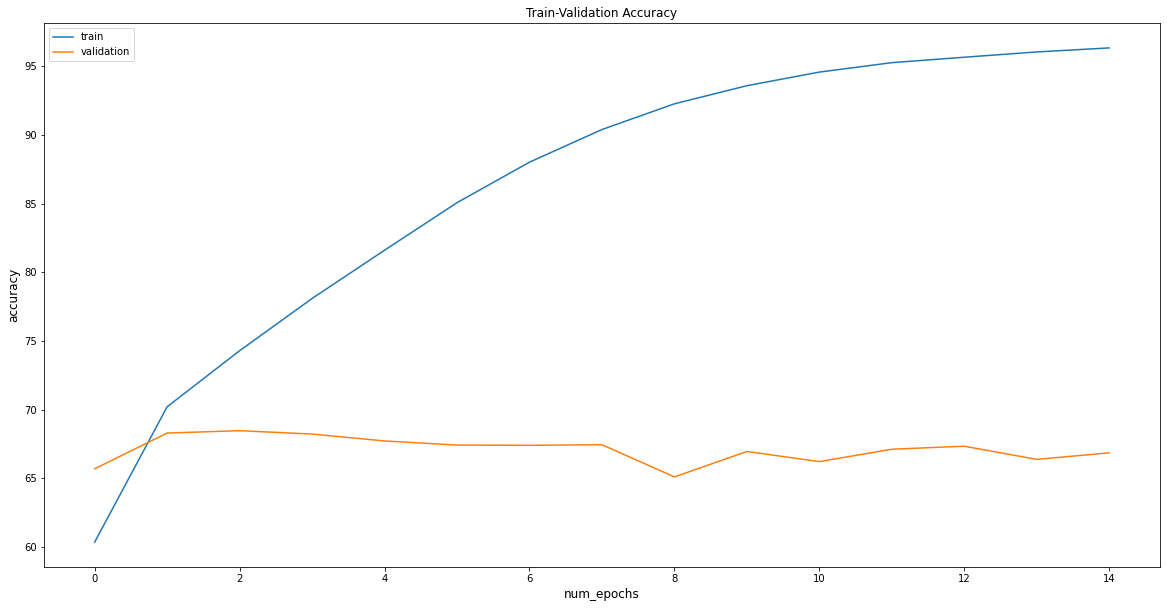

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

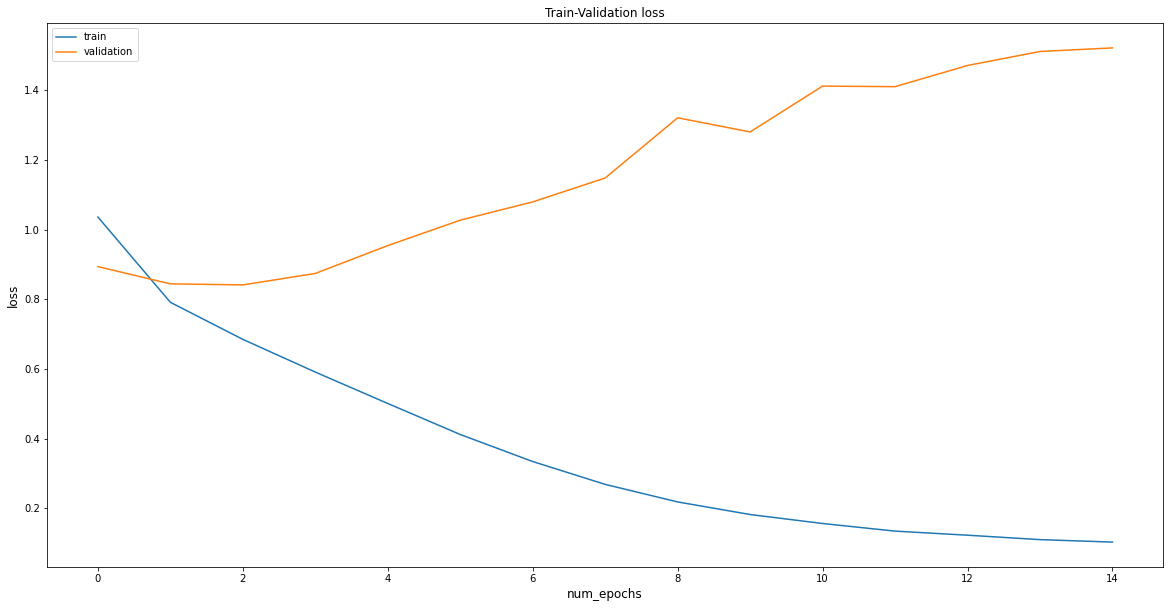

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')